In [2]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import torch

import sys
sys.path.append("..")

from data_loader.kitti_odometry_dataset import KittiOdometryDataset
from data_loader.nuscenes_dataset import NuscenesDataset
from model.monorec.monorec_model import MonoRecModel
from utils import unsqueezer, map_fn, to
from matplotlib import cm

In [5]:
# 0. 准备工作
target_image_size = (256, 512) # 测试图片大小; 原始大小为(370,1226)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
## 设置pretrained model位置
checkpoint_location = Path("../saved/checkpoints/monorec_depth_ref.pth")

## 定义inv depth范围
inv_depth_min_max = [0.33, 0.0025]  # 正常的depth range 3～400

## 加载pretrained model
print("Initializing model...")
monorec_model = MonoRecModel(checkpoint_location=checkpoint_location, inv_depth_min_max=inv_depth_min_max)
monorec_model.to(device)
monorec_model.eval()
print()

Initializing model...



In [19]:
# 创建data
## KITTI
dataset = KittiOdometryDataset("data/kitti", sequences=["07"], target_image_size=target_image_size, frame_count=2,
                               depth_folder="image_depth_annotated", lidar_depth=True, use_dso_poses=True,
                               use_index_mask=None)
# Next three lines are a hack required because Kitti files are incomplete
dataset._dataset_sizes = [1000]
dataset._datasets[0].cam2_files = [f"data/kitti/sequences/07/image_2/{i:06d}.png" for i in range(dataset._dataset_sizes[0])] # 'data/kitti/sequences/07/image_2/0~999.png'
dataset._datasets[0].cam3_files = [f"data/kitti/sequences/07/image_3/{i:06d}.png" for i in range(dataset._dataset_sizes[0])]

## nuscenes
# dataset = NuscenesDataset()

In [20]:
index = 164
# Corresponds to image index 169

# 获取一组数据
batch, depth = dataset.__getitem__(index)  # batch - dict; depth - tensor(1,W=256,H=512)
'''
batch - {
    keyframe - tensor (3,256,512) - 3张图
    keyframe_pose - tensor (4,4) - [R|t] - [R3 t3; 0 0 0 1] kf的内参
    keyframe_intrinsics - tensor - K - kf camera intrinsics (4,4) kf的外参
    frames - list - 是src frame的图片(3,256,512)
    poses - list - 是src frame的相机pose [R|t] (4,4)
    intrinsics - list - 是src frame的内参矩阵 K (4,4)
    sequence - tensor - 属于哪个sequence e.g. seq07 - 7
    image_id - tensor - 这个seq里的哪张图片 - 169
}
depth - tensor(1,256,512)
'''
batch = map_fn(batch, unsqueezer)
depth = map_fn(depth, unsqueezer)

batch = to(batch, device)

In [21]:
print("Starting inference...")
s = time.time()
# 输入进model
with torch.no_grad():
    data = monorec_model(batch)

# 获取输出
prediction = data["result"][0, 0].cpu()  # prediction inverse depth map  [512,256]
mask = data["cv_mask"][0, 0].cpu()
depth = depth[0, 0].cpu()

e = time.time()
print(f"Inference took {e - s}s")

Starting inference...
Inference took 4.988452911376953s


Text(0.5, 1.0, 'gt')

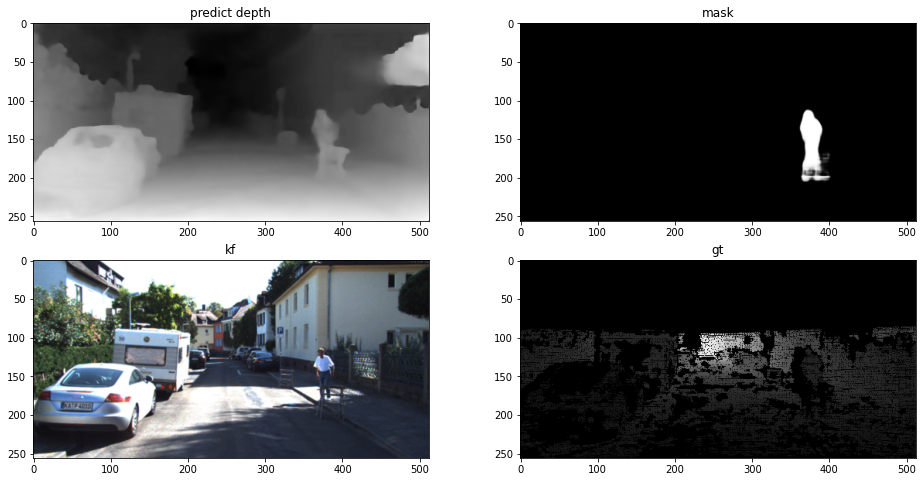

In [37]:
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.subplot(2,2,1)
plt.imshow(prediction.detach().squeeze(), cmap = cm.gray)
plt.title("predict depth")

plt.subplot(2,2,2)
plt.imshow(mask.detach().squeeze(), cmap = cm.gray)
plt.title("mask")

plt.subplot(2,2,3)
plt.imshow(batch["keyframe"][0].permute(1, 2, 0).cpu().numpy() + 0.5)
plt.title("kf")

plt.subplot(2,2,4)
plt.imshow(depth.detach().numpy(), cmap = cm.gray)
plt.title("gt")

# plt.imsave("depth.png", prediction.detach().squeeze(), cmap = cm.gray)
# plt.imsave("mask.png", mask.detach().squeeze(), cmap = cm.gray)
# plt.imsave("kf.png", batch["keyframe"][0].permute(1, 2, 0).cpu().numpy() + 0.5, cmap = cm.gray)
# plt.imsave("gt.png", depth.detach().numpy(), cmap = cm.gray)

In [33]:
def tensor2img(t):
    t = t.squeeze()
    if t.dim() == 3:
        t = torch.permute(t,[1,2,0])
    return t.numpy()

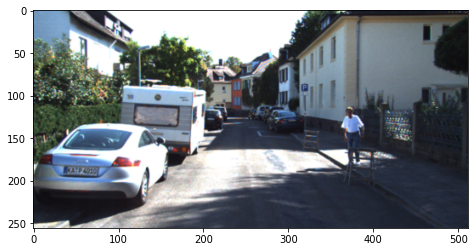

In [39]:
plt.rcParams['figure.figsize'] = (8.0, 4.0)
plt.imshow(tensor2img(batch["keyframe"])+0.5)

In [47]:
frames = batch["frames"]
poses = batch["poses"]
intrinsics = batch["intrinsics"]
for i in range(len(frames)):
    frame = frames[i]
    pose = poses[i]
    intrinsic = intrinsics[i]
    print()
    # plt.imshow(tensor2img(frame)+0.5)
    # plt.show()

SyntaxError: unexpected EOF while parsing (<ipython-input-47-0ffe8b8e9c01>, line 7)